In [1]:
import sys
from scipy.optimize import linear_sum_assignment

sys.path.append("..")
from src import *

Cupy Available= 1


In [10]:
dataset = "zebrafish"
folder = "fft"

In [11]:
dir = Path(f"dataset/{dataset}/{folder}/suite2p/plane0")
meta = DATASETS[dataset]
n_time, Ly, Lx = meta.shape

stats = np.load(dir / "stat.npy", allow_pickle=True)
ops = np.load(dir / "ops.npy", allow_pickle=True).item()
iscell = np.load(dir / "iscell.npy", allow_pickle=True)[:, 0].astype(int)
f_cells = np.load(dir / "F.npy")
f_neuropils = np.load(dir / "Fneu.npy")
spks = np.load(dir / "spks.npy")

## Registration
Registration computes a reference image from a subset of frames and registers all frames to the reference.

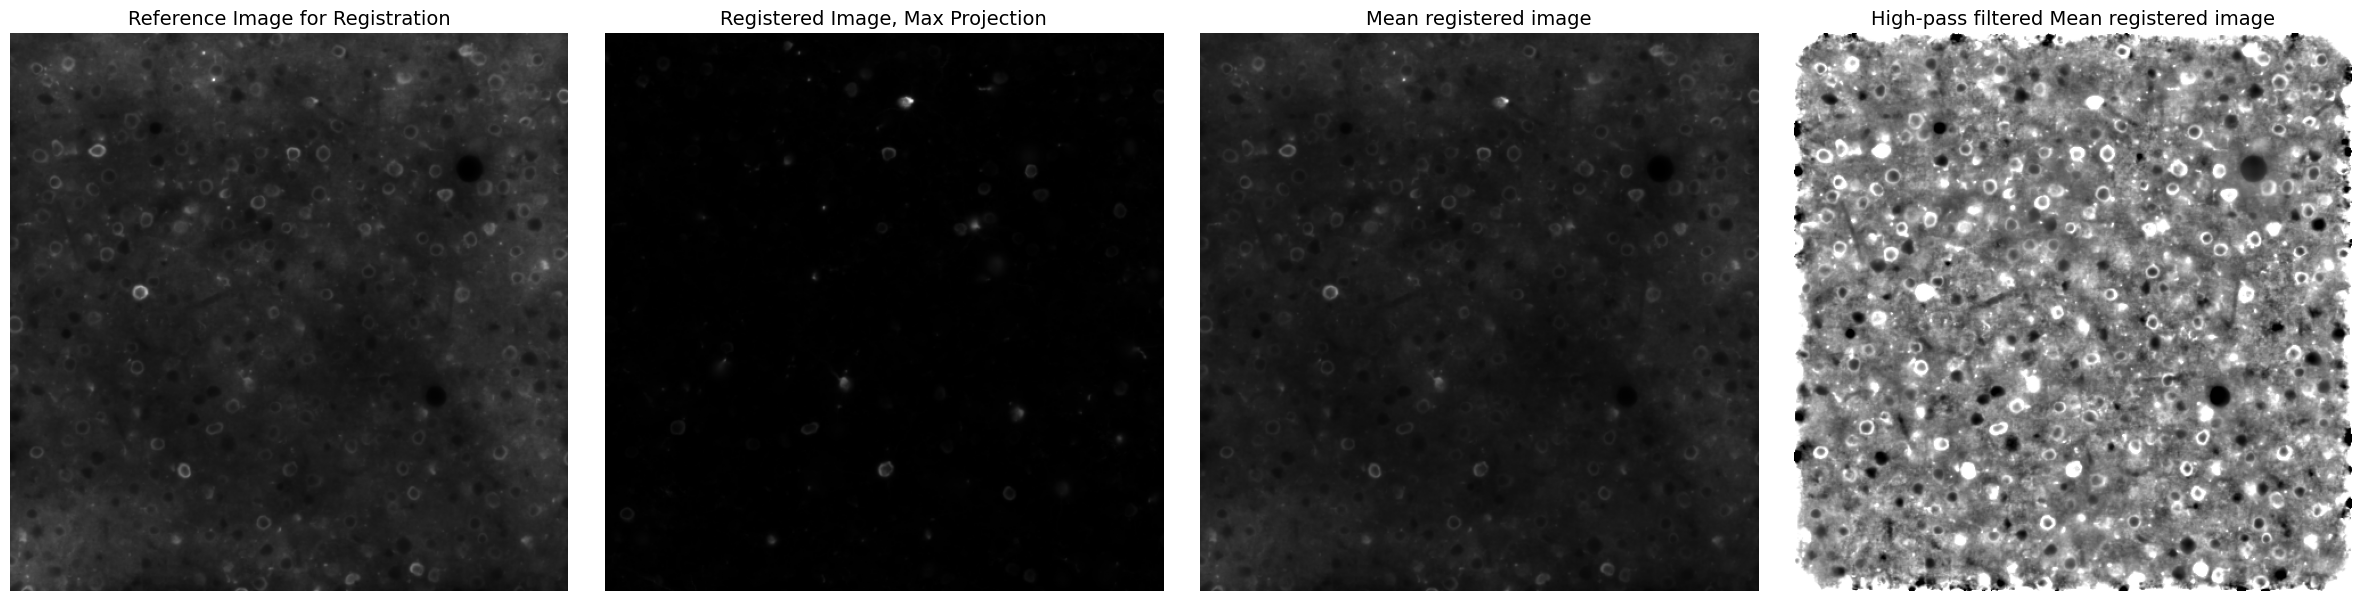

In [ ]:
imshow(
    {
        "Reference Image for Registration": ops["refImg"],
        "Registered Image, Max Projection": ops["max_proj"],
        "Mean registered image": ops["meanImg"],
        "High-pass filtered Mean registered image": ops["meanImgE"],
    },
    size=6,
)

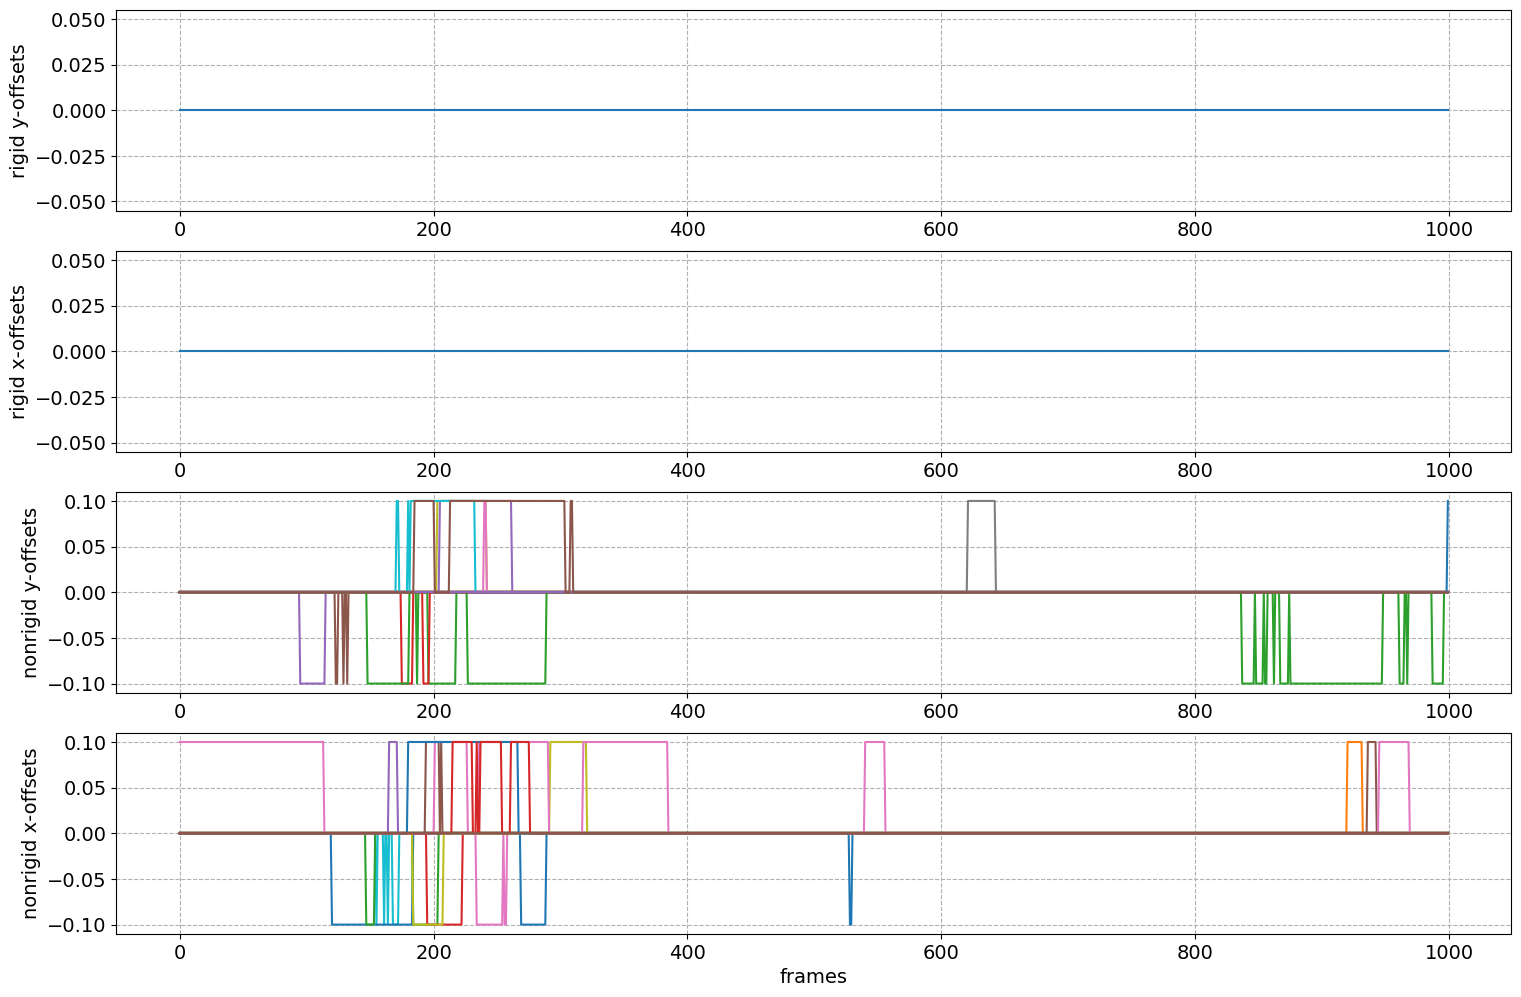

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(4, 1, 1)
plt.plot(ops["yoff"][:1000])
plt.ylabel("rigid y-offsets")

plt.subplot(4, 1, 2)
plt.plot(ops["xoff"][:1000])
plt.ylabel("rigid x-offsets")

plt.subplot(4, 1, 3)
plt.plot(ops["yoff1"][:1000])
plt.ylabel("nonrigid y-offsets")

plt.subplot(4, 1, 4)
plt.plot(ops["xoff1"][:1000])
plt.ylabel("nonrigid x-offsets")
plt.xlabel("frames")

plt.show()

## Detection

ROIs are found by searching for sparse signals that are correlated spatially in the FOV. The ROIs are saved in `stat.npy` as a list of dictionaries which contain the pixels of the ROI and their weights (`stat['ypix']`, `stat['xpix']`, and `stat['lam']`). It also contains other spatial properties of the ROIs such as their aspect ratio and compactness, and properties of the signal such as the skewness of the fluorescence signal.

Some ROIs are defined as "cells" (somatic ROIs) or "not cells" (all other ROIs) depending on their properties, like skewness, compactness, etc. Below we will visualize the ROIs, but please open the files in the suite2p GUI for closer inspection.

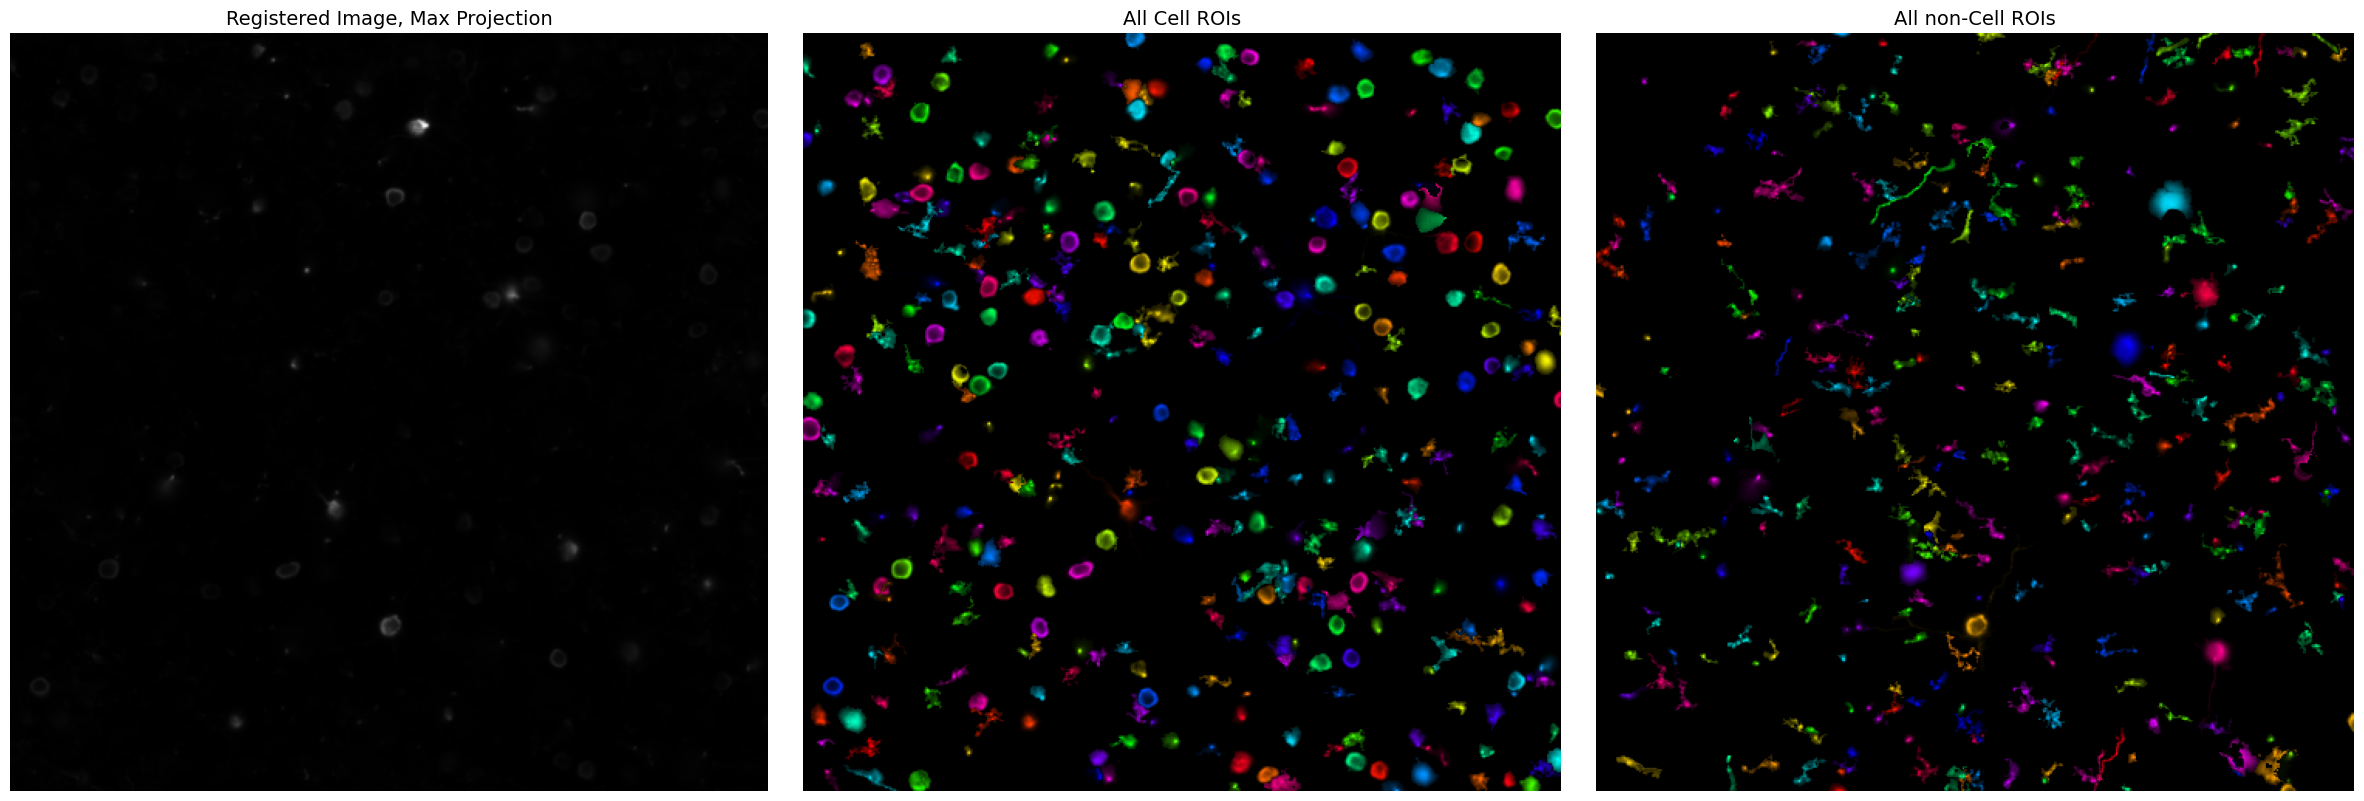

In [23]:
n_cells = len(stats)
h = np.random.rand(n_cells)
hsvs = np.zeros((2, Ly, Lx, 3), dtype=np.float32)

for i, stat in enumerate(stats):
    ypix, xpix, lam = stat["ypix"], stat["xpix"], stat["lam"]
    hsvs[iscell[i], ypix, xpix, 0] = h[i]
    hsvs[iscell[i], ypix, xpix, 1] = 1
    hsvs[iscell[i], ypix, xpix, 2] = lam / lam.max()

from colorsys import hsv_to_rgb

rgbs = np.array([hsv_to_rgb(*hsv) for hsv in hsvs.reshape(-1, 3)]).reshape(hsvs.shape)

imshow(
    {
        "Registered Image, Max Projection": ops["max_proj"],
        "All Cell ROIs": rgbs[1],
        "All non-Cell ROIs": rgbs[0],
    },
    size=8,
)

## Traces

We will load in the fluorescence, the neuropil and the deconvolved traces, and visualize them for a few cells.

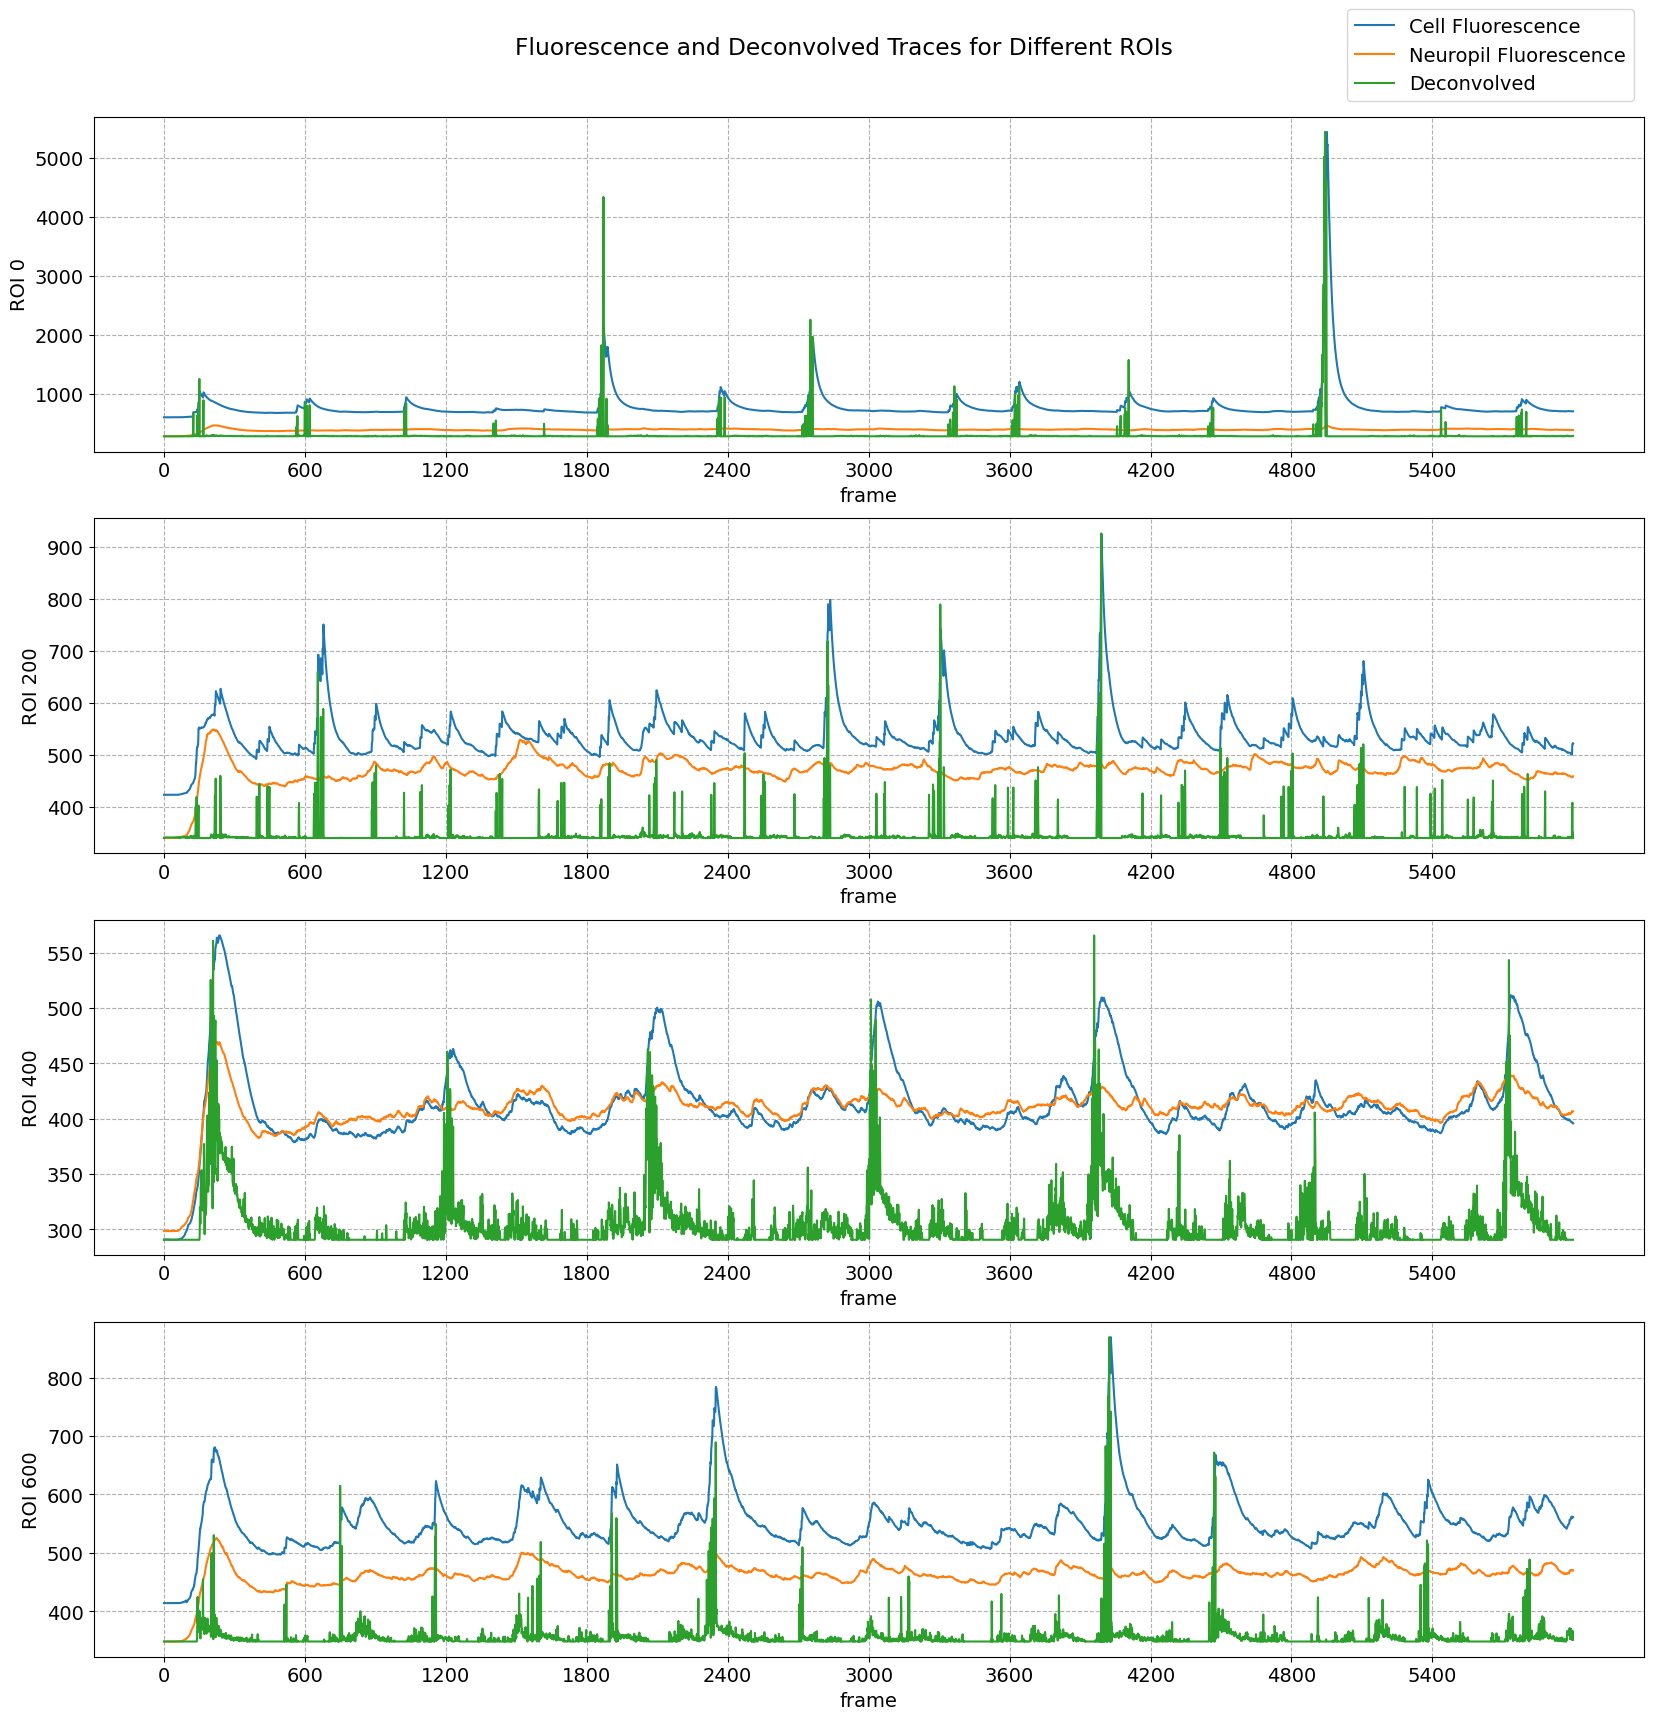

In [14]:
plt.figure(figsize=[20, 20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92)
rois = np.arange(len(f_cells))[::200]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i + 1)
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1] / 10))
    plt.ylabel(f"ROI {roi}", rotation=90)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(1, 1.35))

In [5]:
def create_mask(stat_item, ly, lx):
    """Converts a suite2p ROI 'stat' item into a 2D boolean mask."""
    mask = np.zeros((ly, lx), dtype=bool)
    mask[stat_item["ypix"], stat_item["xpix"]] = True
    return mask


def calculate_iou(mask1, mask2):
    """Calculates the Intersection over Union (IoU) for two boolean masks."""
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1 | mask2)
    if union == 0:
        return 0.0
    return intersection / union


def compare_segmentations(dataset: str,test: str, gt: str="gt", iou_threshold=0.5):
    """
    Compares two suite2p segmentations and computes performance metrics.

    Args:
        gt_dir (str): Path to the ground truth suite2p output directory.
        test_dir (str): Path to the test (e.g., denoised) suite2p output directory.
        iou_threshold (float): The IoU threshold to consider a match a true positive.
    """
    test_dir = Path(f"dataset/{dataset}/{test}/suite2p/plane0")
    gt_dir = Path(f"dataset/{dataset}/{gt}/suite2p/plane0")

    # 1. Load suite2p outputs
    stat_gt = np.load(gt_dir / "stat.npy", allow_pickle=True)
    ops_gt = np.load(gt_dir / "ops.npy", allow_pickle=True).item()

    stat_test = np.load(test_dir / "stat.npy", allow_pickle=True)
    ops_test = np.load(test_dir / "ops.npy", allow_pickle=True).item()

    # Ensure dimensions match
    ly, lx = ops_gt["Ly"], ops_gt["Lx"]
    assert ly == ops_test["Ly"] and lx == ops_test["Lx"]

    n_gt = len(stat_gt)
    n_test = len(stat_test)
    print(f"Found {n_gt} ROIs in Ground Truth and {n_test} ROIs in Test.")

    # 2. Build the IoU matrix
    iou_matrix = np.zeros((n_gt, n_test))

    print("Building IoU matrix...")
    for i in trange(n_gt):
        mask_gt = create_mask(stat_gt[i], ly, lx)
        for j in range(n_test):
            mask_test = create_mask(stat_test[j], ly, lx)
            iou_matrix[i, j] = calculate_iou(mask_gt, mask_test)

    # 3. Match ROIs using the Hungarian algorithm
    # The algorithm finds the minimum cost, so we use 1 - IoU as the cost.
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)

    # 4. Calculate metrics
    matched_ious = iou_matrix[row_ind, col_ind]

    true_positives = np.sum(matched_ious >= iou_threshold)
    false_negatives = n_gt - true_positives
    false_positives = n_test - true_positives

    # Calculate Precision, Recall, and F1-Score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Average IoU for matched cells
    avg_iou_matched = np.mean(matched_ious[matched_ious >= iou_threshold]) if true_positives > 0 else 0.0

    # --- Print Results ---
    print("\n--- Segmentation Performance ---")
    print(f"IoU Threshold: {iou_threshold}")
    print("---------------------------------")
    print(f"True Positives (TP):  {true_positives}")
    print(f"False Positives (FP): {false_positives}")
    print(f"False Negatives (FN): {false_negatives}")
    print("---------------------------------")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1-Score:  {f1_score:.3f}")
    print(f"Average IoU of matched ROIs: {avg_iou_matched:.3f}")
    print("---------------------------------\n")

In [6]:
compare_segmentations(dataset="synthetic", test=f"deepcad")

Found 679 ROIs in Ground Truth and 843 ROIs in Test.
Building IoU matrix...


100%|██████████| 679/679 [02:28<00:00,  4.58it/s]


NameError: name 'linear_sum_assignment' is not defined